# Notebook Preparation

In [1]:
library(dplyr)
library(lme4)
library(jtools)
library(lmerTest)
library(reghelper)
library(lattice)
library(emmeans)
library(ggplot2)
library(jsonlite)
library(glmmTMB)
library(stringr)
library(tidyr)
library(ggeffects)
library(knitr)
library(purrr)
library(forcats)
library(ggrepel)
library(lubridate)
library(gridExtra)
library(progress)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: Matrix


Attaching package: ‘lmerTest’


The following object is masked from ‘package:lme4’:

    lmer


The following object is masked from ‘package:stats’:

    step



Attaching package: ‘reghelper’


The following object is masked from ‘package:base’:

    beta



Attaching package: ‘tidyr’


The following objects are masked from ‘package:Matrix’:

    expand, pack, unpack



Attaching package: ‘ggeffects’


The following object is masked from ‘package:jtools’:

    johnson_neyman



Attaching package: ‘purrr’


The following object is masked from ‘package:jsonlite’:

    flatten



Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union



Attaching package: ‘gridExtra’


The following objec

In [2]:
translate_pvals <- function(pvs){
  scodes <- cut(pvs, breaks = c(0, 0.001, 0.01, 0.05, 0.1, 1), include.lowest = T, labels = c('***', '**', '*', '.', ''))
  return(scodes)
}

In [3]:
bias_colors <- c(
  "Left"         = "#2166AC",  # strong blue
  "Left-Center"  = "#67A9CF",  # light blue
  "Center"       = "#595858",  # gray
  "Science"      = "#4DAF4A",  # green (neutral / evidence)
  "Right-Center" = "#FDAE61",  # light orange
  "Right"        = "#D73027"   # strong red-orange
)

bias_shapes = c(
  "Left"         = 16,  # solid circle
  "Left-Center"  = 17,  # solid triangle
  "Center"       = 7,  # solid square
  "Science"      = 8,  # asterisk
  "Right-Center" = 18,   # empty triangle
  "Right"        = 15    # empty circle
)

noxlabel_theme <- theme(
    axis.text.x = element_blank(), 
    axis.ticks = element_blank(), 
    panel.background = element_rect(fill = "white", colour = "lightgrey", linewidth = 0.5, linetype = "solid"), 
    panel.grid.major = element_line(linewidth = 0.25, linetype = 'solid', colour = alpha("grey70", 0.2)), 
    panel.grid.minor = element_line(linewidth = 0.25, linetype = 'solid', colour = alpha("grey70", 0.1)), 
    panel.grid.major.x = element_blank(),
    axis.text.y = element_text(size = 40/.pt),
    axis.title.y = element_text(size = 40/.pt),
    axis.title.x = element_text(size = 40/.pt),
    legend.position="bottom",
    legend.title = element_blank(),
    legend.box.margin=margin(-25,0,0,0),
    legend.key = element_blank(),
    legend.text=element_text(size=46/.pt),
    strip.text = element_text(size=36/.pt)
) 

xlabel_theme <- theme(
    panel.background = element_rect(fill = "white", colour = "lightgrey", linewidth = 0.5, linetype = "solid"), 
    panel.grid.major = element_line(linewidth = 0.25, linetype = 'solid', colour = alpha("grey70", 0.2)), 
    panel.grid.minor = element_line(linewidth = 0.25, linetype = 'solid', colour = alpha("grey70", 0.1)), 
    panel.grid.major.x = element_blank(),
    axis.text.x = element_text(size = 40/.pt),
    axis.text.y = element_text(size = 40/.pt),
    axis.title.y = element_text(size = 40/.pt),
    axis.title.x = element_text(size = 40/.pt),
    legend.position="bottom",
    legend.title = element_blank(),
    legend.box.margin=margin(-5,0,0,0),
    legend.key = element_blank(),
    legend.text=element_text(size=40/.pt),
    strip.text = element_text(size=36/.pt)
) 

dodge <- position_dodge(width=0.9)

sig_label <- geom_text(aes(y=ucl_perc, label=sc), vjust = -0.4, position = dodge, color = "black", size = 15/.pt)

options(width = 1000)
options(
  scipen = 10,
  digits = 4
)

# Data Preparation

In [38]:
data <- read.table(file = 'file.tsv', sep='\t', header = TRUE, quote = "\"", stringsAsFactors = FALSE)

table(data$bias, useNA = "ifany")

head(data, 5)


        1_Left  2_Left-Center       3_Center      4_Science 5_Right-Center        6_Right 
         13576          50904          42899         200400          18195          26891 

,newsid,news_domain,date,news_workids,bias,hp,X1p_ntweets
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>
1,6,cnn.com,2019-01-01,"['54760018', '6471766', '22751412', '53467124']",2_Left-Center,True,3
2,12,sciencealert.com,2019-01-01,['54695343'],4_Science,False,6
3,18,cnn.com,2019-01-01,['54777480'],2_Left-Center,False,1
4,19,thehill.com,2019-01-01,"['3349008', '2415900', '4888874', '4364249']",3_Center,False,0
5,20,medicalxpress.com,2019-01-01,"['3156637', '54776424']",4_Science,False,0


### Table 1

In [5]:
pairs_count <- data %>%
  count(bias, name = "n") %>%
  arrange(bias, desc(n))

print(pairs_count)

print(count(data))

            bias      n
1         1_Left  13576
2  2_Left-Center  50904
3       3_Center  42899
4      4_Science 200400
5 5_Right-Center  18195
6        6_Right  26891
       n
1 352865


### Table 2

In [6]:
pairs <- data %>%
  select(bias, news_domain) %>%
  distinct() %>%
  arrange(bias, news_domain)

print(pairs)

             bias            news_domain
1          1_Left           alternet.org
2          1_Left       commondreams.org
3          1_Left          newyorker.com
4          1_Left              nymag.com
5          1_Left       rollingstone.com
6          1_Left              salon.com
7          1_Left      thedailybeast.com
8          1_Left       theintercept.com
9          1_Left          thenation.com
10         1_Left                vox.com
11  2_Left-Center    businessinsider.com
12  2_Left-Center                cnn.com
13  2_Left-Center            nbcnews.com
14  2_Left-Center                npr.org
15  2_Left-Center            nytimes.com
16  2_Left-Center        theatlantic.com
17  2_Left-Center               time.com
18  2_Left-Center           usatoday.com
19  2_Left-Center     washingtonpost.com
20  2_Left-Center              wired.com
21       3_Center        arstechnica.com
22       3_Center           bigthink.com
23       3_Center               cnet.com
24       3_Cente

# Share of Polarizing Headlines in Science News by Bias (in #all news articles)

In [7]:
new_data <- data
new_data$bias <- factor(new_data$bias)
new_data$bias <- relevel(new_data$bias, ref = "3_Center")
new_data$hp <- ifelse(tolower(new_data$hp) == "true", 1, 0)
new_data$news_domain <- factor(new_data$news_domain)

table(new_data$bias, useNA = "ifany")


      3_Center         1_Left  2_Left-Center      4_Science 5_Right-Center        6_Right 
         42899          13576          50904         200400          18195          26891 

In [8]:
start_time <- Sys.time()
model_bias2hp <- glmmTMB(hp ~ 1 + bias + (1|news_domain), data=new_data, family="binomial", control=glmmTMBControl(rank_check="adjust", parallel=2))
end_time <- Sys.time()
elapsed_time <- end_time - start_time
elapsed_time

Time difference of 3.95 secs

In [9]:
s <- summary(emmeans(model_bias2hp, ~ bias, infer=c(TRUE,TRUE), type="response"),infer=c(TRUE,TRUE), type="response")
s$sc <- translate_pvals(s$p.value)
s$bias <- factor(s$bias, levels = c("1_Left", "2_Left-Center", "3_Center", "4_Science", "5_Right-Center", "6_Right"), labels = c("Left", "Left-Center", "Center", "Science", "Right-Center", "Right"))
s

,bias,prob,SE,df,asymp.LCL,asymp.UCL,null,z.ratio,p.value,sc
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,Center,0.04446,0.010437,Inf,0.027940,0.07003,0.5,-12.486,8.902e-36,***
2,Left,0.29266,0.050364,Inf,0.204349,0.39996,0.5,-3.627,2.864e-04,***
3,Left-Center,0.11816,0.025225,Inf,0.076957,0.17719,0.5,-8.303,1.017e-16,***
4,Science,0.01389,0.003359,Inf,0.008632,0.02227,0.5,-17.380,1.161e-67,***
5,Right-Center,0.13513,0.028470,Inf,0.088361,0.20119,0.5,-7.620,2.533e-14,***
6,Right,0.20801,0.039971,Inf,0.140336,0.29705,0.5,-5.510,3.583e-08,***


### Figure 2

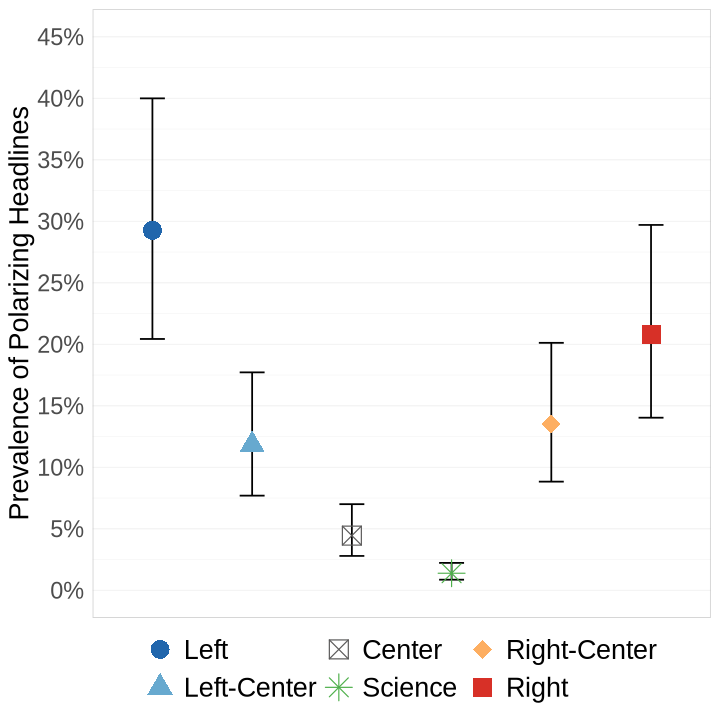

In [10]:
width=6
height=6

s$perc <- (s$prob)
s$lcl_perc <- (s$asymp.LCL)
s$ucl_perc <- (s$asymp.UCL)

p <- ggplot(s, aes(x=bias, y=perc, fill=bias))

p <- p + 
geom_errorbar(aes(ymin = lcl_perc, ymax = ucl_perc), width = 0.25) + 
geom_point(aes(colour=bias, shape=bias), size=5) +
scale_color_manual(values = bias_colors) +
scale_shape_manual(values = bias_shapes) +
scale_y_continuous(labels = scales::label_percent(), breaks = scales::pretty_breaks(n = 10), limits = c(0, 0.45))+
labs(x="", y="Prevalence of Polarizing Headlines", fill="Bias", colour="Bias", shape="Bias") + noxlabel_theme + 
theme(
    axis.title.y = element_text(size = 46/.pt)
) 

options(repr.plot.width=width, repr.plot.height=height)
p

# Share of Polarizing Headlines in All Articles vs. in All Shares

In [11]:
news_data <- data
news_data$group <- "all"

social_data <- data %>% filter(X1p_ntweets > 0) #%>% filter(X1p_ntweets < 500)
social_data$group <- "shared"

combined_data <- rbind(
  transform(news_data, weight = 1),
  transform(social_data, weight = X1p_ntweets) #X1p_ntweets
)

combined_data$bias <- factor(combined_data$bias)
combined_data$bias <- relevel(combined_data$bias, ref = "3_Center")
combined_data$hp <- ifelse(tolower(combined_data$hp) == "true", 1, 0)
combined_data$news_domain <- factor(combined_data$news_domain)

model_bias2hp_comb <- glmmTMB(hp ~ 1 + group*bias + (1+group|news_domain), data=combined_data, family="binomial", weights=weight, control=glmmTMBControl(rank_check="adjust", parallel=2))

In [12]:
s <- summary(emmeans(model_bias2hp_comb, ~ group | bias, infer=c(TRUE,TRUE), type="response"))
s

,group,bias,prob,SE,df,asymp.LCL,asymp.UCL,null,z.ratio,p.value
,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,all,3_Center,0.04424,0.010500,Inf,0.027661,0.07003,0.5,-12.374,3.631e-35
2,shared,3_Center,0.05631,0.014571,Inf,0.033691,0.09267,0.5,-10.281,8.618e-25
3,all,1_Left,0.29210,0.050880,Inf,0.203023,0.40060,0.5,-3.598,3.213e-04
4,shared,1_Left,0.42919,0.066339,Inf,0.306637,0.56109,0.5,-1.053,2.923e-01
5,all,2_Left-Center,0.11816,0.025519,Inf,0.076566,0.17800,0.5,-8.207,2.265e-16
6,shared,2_Left-Center,0.19670,0.042744,Inf,0.125954,0.29383,0.5,-5.201,1.978e-07
7,all,4_Science,0.01382,0.003380,Inf,0.008547,0.02228,0.5,-17.209,2.288e-66
8,shared,4_Science,0.01338,0.003599,Inf,0.007889,0.02262,0.5,-15.779,4.355e-56
9,all,5_Right-Center,0.13417,0.028629,Inf,0.087258,0.20076,0.5,-7.566,3.851e-14


In [13]:
e <- contrast(regrid(emmeans(model_bias2hp_comb, ~ group | bias, infer=c(TRUE,TRUE), type="response"), "log"), method="revpairwise", by="bias")
s <- summary(e,infer=c(TRUE,TRUE), type="response")
s$sc <- translate_pvals(s$p.value)
s$bias <- factor(s$bias, levels = c("1_Left", "2_Left-Center", "3_Center", "4_Science", "5_Right-Center", "6_Right"), labels = c("Left", "Left-Center", "Center", "Science", "Right-Center", "Right"))
s

,contrast,bias,ratio,SE,df,asymp.LCL,asymp.UCL,null,z.ratio,p.value,sc
,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,shared / all,Center,1.2730,0.2113,Inf,0.9194,1.763,1,1.4540,0.14595505,
2,shared / all,Left,1.4693,0.1566,Inf,1.1923,1.811,1,3.6099,0.00030637,***
3,shared / all,Left-Center,1.6647,0.2277,Inf,1.2733,2.176,1,3.7263,0.00019435,***
4,shared / all,Science,0.9683,0.1646,Inf,0.6940,1.351,1,-0.1894,0.84980496,
5,shared / all,Right-Center,1.7338,0.2394,Inf,1.3227,2.273,1,3.9857,0.00006729,***
6,shared / all,Right,1.5111,0.1835,Inf,1.1911,1.917,1,3.4006,0.00067243,***


### Figure 3

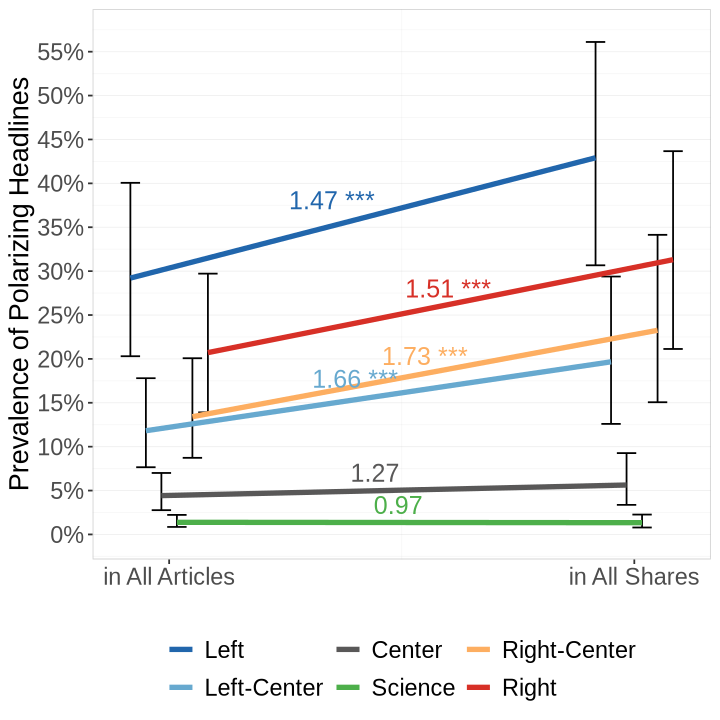

In [14]:
width=6
height=6

e <- summary(emmeans(model_bias2hp_comb, ~ group | bias, infer=c(TRUE,TRUE), type="response"))
e$bias <- factor(e$bias, levels = c("1_Left", "2_Left-Center", "3_Center", "4_Science", "5_Right-Center", "6_Right"), labels = c("Left", "Left-Center", "Center", "Science", "Right-Center", "Right"))
e$lcl_perc <- (e$asymp.LCL)
e$ucl_perc <- (e$asymp.UCL)
e$xval <- ifelse(tolower(e$group) == "shared", 1, 0)

midpoints_df <- e %>%
  group_by(bias) %>%
  summarise(y = mean(range(prob))+0.02) %>%
  mutate(
    bias_num = as.numeric(bias),
    x = 0.5 -0.2 + 0.05 * bias_num
  )

c <- contrast(regrid(emmeans(model_bias2hp_comb, ~ group | bias, infer=c(TRUE,TRUE), type="response"), "log"), method="revpairwise")
s <- summary(c,infer=c(TRUE,TRUE), type="response")
s$sc <- translate_pvals(s$p.value)
s$bias <- factor(s$bias, levels = c("1_Left", "2_Left-Center", "3_Center", "4_Science", "5_Right-Center", "6_Right"), labels = c("Left", "Left-Center", "Center", "Science", "Right-Center", "Right"))
s <- s %>% left_join(midpoints_df, by = c("bias" = "bias"))
s <- s %>% mutate(ratio_str = sprintf("%.2f", ratio), label = paste0(ratio_str, " ", sc))

p <- ggplot(e, aes(x=xval, y=prob, shape=bias))

dodge <- position_dodge(width=0.2)

p <- p + 
geom_errorbar(aes(ymin = lcl_perc, ymax = ucl_perc), position=dodge, width=0.25) + 
geom_line(aes(colour=bias), position = dodge, linewidth=1.5) + 
scale_x_continuous(breaks = c(0, 1), labels = c("in All Articles", "in All Shares"))+
scale_y_continuous(labels = scales::label_percent(), breaks = scales::pretty_breaks(n = 10), limits = c(0, 0.57))+
scale_color_manual(values = bias_colors) +
scale_shape_manual(values = bias_shapes) +
labs(x="", y="Prevalence of Polarizing Headlines", colour="Bias") + 
xlabel_theme + 
geom_text(
    data = s, 
    aes(x = x, y = y, label = label, color=bias), 
    inherit.aes = FALSE,
    size = 15 / .pt,
    show.legend = FALSE
) + 
theme(
    axis.title.y = element_text(size = 46/.pt)
) 


options(repr.plot.width=width, repr.plot.height=height)
p

# Comparison for News Outlets: Polarizing Headlines in All Articles vs in all Shares

In [15]:
news_data <- data %>% select(hp, bias, news_domain, X1p_ntweets)
news_data$hp <- ifelse(tolower(news_data$hp) == "true", 1, 0)

outlet_summary <- news_data %>%
  group_by(news_domain, bias) %>%
  summarise(
    n_articles = n(),
    hp_articles = sum(hp == 1),
    hp_share_all = hp_articles / n_articles,

    total_tweets = sum(X1p_ntweets),
    hp_tweets = sum(X1p_ntweets[hp == 1]),
    hp_tweet_share = hp_tweets / total_tweets,

    ratio = hp_tweet_share / hp_share_all
  ) %>%
  ungroup()

`summarise()` has grouped output by 'news_domain'. You can override using the `.groups` argument.


### Figure 7

news_domain,bias,n_articles,hp_articles,hp_share_all,total_tweets,hp_tweets,hp_tweet_share,ratio,pol_bias
<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
alternet.org,1_Left,1996,864,0.43287,880,518,0.5886,1.3599,Left
breitbart.com,6_Right,4935,523,0.10598,4473,2224,0.4972,4.6916,Right
cnn.com,2_Left-Center,6855,624,0.09103,50155,8871,0.1769,1.9430,Left-Center
foxnews.com,6_Right,3482,174,0.04997,5196,1060,0.2040,4.0824,Right
newyorker.com,1_Left,255,37,0.14510,2287,504,0.2204,1.5188,Left
nypost.com,5_Right-Center,3805,231,0.06071,5095,921,0.1808,2.9775,Right-Center
rollingstone.com,1_Left,373,107,0.28686,2198,1006,0.4577,1.5955,Left
theblaze.com,6_Right,591,193,0.32657,3000,941,0.3137,0.9605,Right
thedailybeast.com,1_Left,1233,248,0.20114,2185,883,0.4041,2.0092,Left


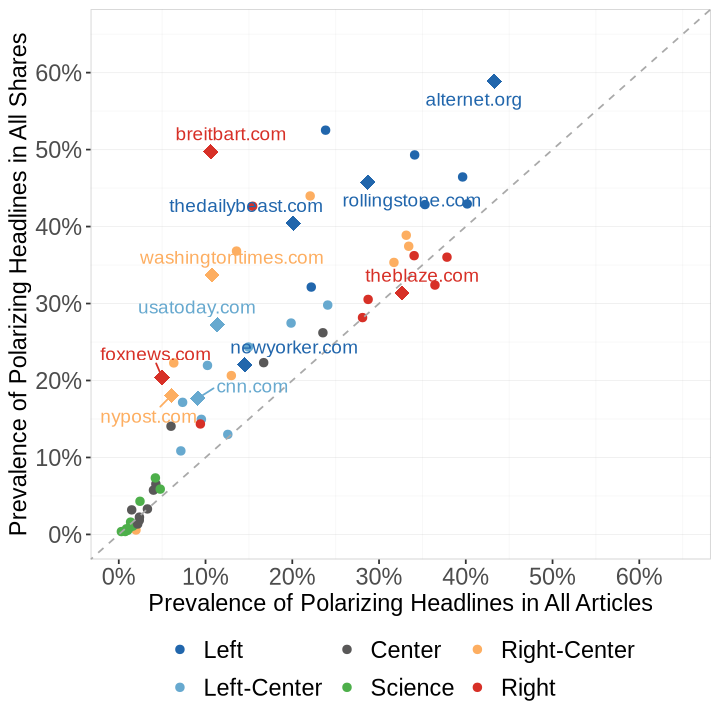

In [16]:
width=6
height=6

outlet_summary$pol_bias <- factor(outlet_summary$bias, levels = c("1_Left", "2_Left-Center", "3_Center", "4_Science", "5_Right-Center", "6_Right"), labels = c("Left", "Left-Center", "Center", "Science", "Right-Center", "Right"))

# 3️⃣ Define labeled outlets for highlighting
labeled <- c("breitbart.com", "alternet.org", "foxnews.com", "theblaze.com", 
             "cnn.com", "newyorker.com", "thedailybeast.com", "rollingstone.com", 
             "nypost.com", "washingtontimes.com", "usatoday.com")

labeled_df <- outlet_summary %>% filter(news_domain %in% labeled)
labeled_df
unlabeled_points <- outlet_summary %>% filter(!news_domain %in% labeled)

p <- ggplot(outlet_summary, aes(x = hp_share_all, y = hp_tweet_share, color=pol_bias)) +
geom_point(data = unlabeled_points, size = 2) +
geom_point(data = labeled_df, size = 4, shape = 18, show.legend = FALSE) +
scale_x_continuous(labels = scales::label_percent(), breaks = scales::pretty_breaks(n = 10), limits = c(0, 0.65))+
scale_y_continuous(labels = scales::label_percent(), breaks = scales::pretty_breaks(n = 10), limits = c(0, 0.65))+
scale_color_manual(values = bias_colors) +
labs(
  x = "Prevalence of Polarizing Headlines in All Articles",
  y = "Prevalence of Polarizing Headlines in All Shares",
)+
geom_abline(slope = 1, intercept = 0, linetype = "dashed", color = "darkgray") +
geom_text_repel(data = labeled_df, aes(label = news_domain), size = 4, max.overlaps = 7, box.padding = 0.4, show.legend = FALSE) + 
xlabel_theme + theme(plot.title = element_text(hjust = 0.5)) + 
theme(
    axis.title.y = element_text(size = 40/.pt),
    axis.title.x = element_text(size = 40/.pt)
) 

options(repr.plot.width=width, repr.plot.height=height)
p

# Polarization by categorical Topic

In [17]:
newsid2topic <- fromJSON('kmeans_20cluster_newsid2topic.json')
newsid2topic$newsid <- as.character(newsid2topic$newsid)

data <- data %>% select(-any_of("kmeans_topic"))
data <- left_join(data, newsid2topic, by = "newsid")
data$topic <- data$kmeans_topic

In [18]:
all_unique_topics <- unique(unlist(data$topic))
all_unique_topics <- sort(all_unique_topics)
all_unique_topics

[1]  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29

## Number of articles per topic

In [19]:
new_data <- data %>% select(hp, topic, bias, news_domain, X1p_ntweets)

new_data$hp <- ifelse(tolower(new_data$hp) == "true", 1, 0)
new_data$bias <- factor(new_data$bias)
new_data$bias <- relevel(new_data$bias, ref = "3_Center")
new_data$news_domain <- factor(new_data$news_domain)

# Overall table of bias counts
print(table(new_data$bias, useNA = "ifany"))

results <- list()

for (target_topic in all_unique_topics) {
    print(target_topic)
    
    window_data <- new_data %>% filter(sapply(topic, function(x) target_topic %in% x))
    #print(table(window_data$bias, useNA = "ifany"))                                         

    # Count number of articles per bias
    narticles_df <- as.data.frame(table(window_data$bias, useNA = "ifany"))
    names(narticles_df) <- c("bias", "n_articles")
    
    # Count number of shared articles per bias
    window_data_shared <- window_data %>% filter(X1p_ntweets > 0)
    nsharedarticles_df <- as.data.frame(table(window_data_shared$bias, useNA = "ifany"))
    names(nsharedarticles_df) <- c("bias", "n_shared_articles")
    
    # Merge counts
    counts_df <- narticles_df %>% left_join(nsharedarticles_df, by = "bias")
    
    results[[as.character(target_topic)]] <- counts_df
    #print(counts_df)
    flush.console()
}


      3_Center         1_Left  2_Left-Center      4_Science 5_Right-Center        6_Right 
         42899          13576          50904         200400          18195          26891 
[1] 0
[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9
[1] 10
[1] 11
[1] 12
[1] 13
[1] 14
[1] 15
[1] 16
[1] 17
[1] 18
[1] 19
[1] 20
[1] 21
[1] 22
[1] 23
[1] 24
[1] 25
[1] 26
[1] 27
[1] 28
[1] 29


In [20]:
num_articles_results <- bind_rows(
  lapply(names(results), function(topic) {
    df <- results[[topic]]
    df$topic <- as.numeric(topic)
    df
  })
)

In [21]:
bias_totals <- new_data %>%
  group_by(bias) %>%
  summarise(total_articles = n(), .groups = "drop")

num_articles_results <- num_articles_results %>%
  left_join(bias_totals, by = "bias") %>%
  mutate(prop = n_articles / total_articles)

## Number of shares per topic

In [22]:
new_data <- data %>% select(hp, topic, bias, news_domain, X1p_ntweets)

new_data$hp <- ifelse(tolower(new_data$hp) == "true", 1, 0)
new_data$bias <- factor(new_data$bias)
new_data$bias <- relevel(new_data$bias, ref = "3_Center")
new_data$news_domain <- factor(new_data$news_domain)

# Overall table of bias counts
print(table(new_data$bias, useNA = "ifany"))

results <- list()

for (target_topic in all_unique_topics) {
    print(target_topic)
    
    window_data <- new_data %>% filter(sapply(topic, function(x) target_topic %in% x))

    # Count number of shares (tweets) per bias
    nshares_df <- window_data %>%
      group_by(bias) %>%
      summarise(
        n_shares = sum(X1p_ntweets, na.rm = TRUE),
        .groups = "drop"
      )
    
    results[[as.character(target_topic)]] <- nshares_df
    flush.console()
}


      3_Center         1_Left  2_Left-Center      4_Science 5_Right-Center        6_Right 
         42899          13576          50904         200400          18195          26891 
[1] 0
[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9
[1] 10
[1] 11
[1] 12
[1] 13
[1] 14
[1] 15
[1] 16
[1] 17
[1] 18
[1] 19
[1] 20
[1] 21
[1] 22
[1] 23
[1] 24
[1] 25
[1] 26
[1] 27
[1] 28
[1] 29


In [23]:
num_shares_results <- bind_rows(
  lapply(names(results), function(topic) {
    df <- results[[topic]]
    df$topic <- as.numeric(topic)
    df
  })
)

In [24]:
bias_totals <- new_data %>%
  group_by(bias) %>%
  summarise(
    total_shares = sum(X1p_ntweets, na.rm = TRUE),
    .groups = "drop"
  )

num_shares_results <- num_shares_results %>%
  left_join(bias_totals, by = "bias") %>%
  mutate(prop = n_shares / total_shares)

num_shares_results

bias,n_shares,topic,total_shares,prop
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
3_Center,1735,0,41796,0.041511
1_Left,1228,0,40709,0.030165
2_Left-Center,13321,0,291121,0.045758
4_Science,16321,0,105968,0.154018
5_Right-Center,285,0,12506,0.022789
6_Right,334,0,33502,0.009970
3_Center,362,1,41796,0.008661
1_Left,394,1,40709,0.009678
2_Left-Center,4150,1,291121,0.014255


## Polarization per Topic

In [25]:
new_data <- data %>% select(hp, topic, bias, news_domain, X1p_ntweets)

new_data$hp <- ifelse(tolower(new_data$hp) == "true", 1, 0)
new_data$bias <- factor(new_data$bias)
new_data$bias <- relevel(new_data$bias, ref = "3_Center")
new_data$news_domain <- factor(new_data$news_domain)

print(table(new_data$bias, useNA = "ifany"))                                         

results <- list()
for (target_topic in all_unique_topics) {
    print(target_topic)
    window_data <- new_data %>% filter(sapply(topic, function(x) target_topic %in% x))    
    print(table(window_data$bias, useNA = "ifany"))                                         
    flush.console()
    if (nrow(window_data) > 10) {
        tryCatch({
            model_rip <- glmmTMB(hp ~ 1 + bias + (1|news_domain), data=window_data, family="binomial", control=glmmTMBControl(rank_check="adjust", parallel=2))
    
            s <- summary(emmeans(model_rip, ~ bias, infer=c(TRUE,TRUE), type="response"),infer=c(TRUE,TRUE), type="response")
            s$sc <- translate_pvals(s$p.value)
            s
        
            results[[as.character(target_topic)]] <- s
            print(s)
            flush.console()
        }, error = function(e) {
            message("Skipping topic = ", target_topic, " due to error: ", e$message)
        })
    }
}


      3_Center         1_Left  2_Left-Center      4_Science 5_Right-Center        6_Right 
         42899          13576          50904         200400          18195          26891 
[1] 0

      3_Center         1_Left  2_Left-Center      4_Science 5_Right-Center        6_Right 
          2770            657           2912          19209            845           2120 
 bias              prob      SE  df asymp.LCL asymp.UCL null z.ratio p.value sc 
 3_Center       0.00631 0.00310 Inf   0.00241   0.01644  0.5 -10.247  <.0001 ***
 1_Left         0.07341 0.02825 Inf   0.03392   0.15169  0.5  -6.105  <.0001 ***
 2_Left-Center  0.01485 0.00546 Inf   0.00720   0.03039  0.5 -11.232  <.0001 ***
 4_Science      0.00457 0.00174 Inf   0.00216   0.00963  0.5 -14.048  <.0001 ***
 5_Right-Center 0.03018 0.01311 Inf   0.01277   0.06964  0.5  -7.748  <.0001 ***
 6_Right        0.05133 0.01960 Inf   0.02400   0.10639  0.5  -7.248  <.0001 ***

Confidence level used: 0.95 
Intervals are back-transformed 

In [26]:
prevalence_pol_results <- bind_rows(
  lapply(names(results), function(topic) {
    df <- results[[topic]]
    df$topic <- as.numeric(topic)  # Add numeric center column
    df
  })
)

## Overrepresentation Social Media

In [27]:
new_data <- data %>% select(hp, topic, bias, news_domain, X1p_ntweets)

news_data <- new_data
news_data$group <- "all"

shared_weighted_data <- new_data %>% filter(X1p_ntweets > 0) #%>% filter(X1p_ntweets < 500)
shared_weighted_data$group <- "shared_weighted"

combined_data <- rbind(
  transform(news_data, weight = 1),
  transform(shared_weighted_data, weight = X1p_ntweets)
)

combined_data$hp <- ifelse(tolower(combined_data$hp) == "true", 1, 0)
combined_data$bias <- factor(combined_data$bias)
combined_data$bias <- relevel(combined_data$bias, ref = "3_Center")
combined_data$news_domain <- factor(combined_data$news_domain)

print(table(combined_data$bias, useNA = "ifany"))                                         

sharing_results <- list()
for (target_topic in all_unique_topics) {
    print(target_topic)
    window_data <- combined_data %>% filter(sapply(topic, function(x) target_topic %in% x))    
    print(table(window_data$bias, useNA = "ifany"))                                         
    flush.console()
    if (nrow(window_data) > 10) {
        tryCatch({
            model_hp_shares <- glmmTMB(hp ~ 1 + group*bias + (1+group|news_domain), data=window_data, family="binomial", weights=weight, control=glmmTMBControl(rank_check="adjust", parallel=2))

            e <- contrast(regrid(emmeans(model_hp_shares, ~ group | bias, infer=c(TRUE,TRUE), type="response"), "log"), method = "revpairwise", by="bias")
            s <- summary(e,infer=c(TRUE,TRUE), type="response")
            s$sc <- translate_pvals(s$p.value)
        
            sharing_results[[as.character(target_topic)]] <- s
            print(summary(s))
            flush.console()
        }, error = function(e) {
            message("Skipping topic = ", target_topic, " due to error: ", e$message)
        })
    }
}


      3_Center         1_Left  2_Left-Center      4_Science 5_Right-Center        6_Right 
         56235          20074          83595         245622          22285          33254 
[1] 0

      3_Center         1_Left  2_Left-Center      4_Science 5_Right-Center        6_Right 
          3470            911           4863          25117            983           2320 
bias = 3_Center:
 contrast              ratio    SE  df asymp.LCL asymp.UCL null z.ratio p.value sc
 shared_weighted / all 0.513 0.480 Inf    0.0817      3.21    1  -0.714  0.4755   

bias = 1_Left:
 contrast              ratio    SE  df asymp.LCL asymp.UCL null z.ratio p.value sc
 shared_weighted / all 0.905 0.532 Inf    0.2860      2.86    1  -0.170  0.8652   

bias = 2_Left-Center:
 contrast              ratio    SE  df asymp.LCL asymp.UCL null z.ratio p.value sc
 shared_weighted / all 1.448 0.790 Inf    0.4967      4.22    1   0.678  0.4976   

bias = 4_Science:
 contrast              ratio    SE  df asymp.LCL asymp.

Warning message in finalizeTMB(TMBStruc, obj, fit, h, data.tmb.old):
“Model convergence problem; singular convergence (7). See vignette('troubleshooting'), help('diagnose')”


bias = 3_Center:
 contrast               ratio     SE  df asymp.LCL asymp.UCL null z.ratio p.value sc
 shared_weighted / all 0.0373 0.0588 Inf    0.0017     0.820    1  -2.086  0.0370 * 

bias = 1_Left:
 contrast               ratio     SE  df asymp.LCL asymp.UCL null z.ratio p.value sc
 shared_weighted / all 0.8928 0.7020 Inf    0.1912     4.169    1  -0.144  0.8853   

bias = 2_Left-Center:
 contrast               ratio     SE  df asymp.LCL asymp.UCL null z.ratio p.value sc
 shared_weighted / all 0.9621 0.4438 Inf    0.3896     2.376    1  -0.084  0.9332   

bias = 4_Science:
 contrast               ratio     SE  df asymp.LCL asymp.UCL null z.ratio p.value sc
 shared_weighted / all 0.1042 0.1059 Inf    0.0142     0.764    1  -2.225  0.0261 * 

bias = 5_Right-Center:
 contrast               ratio     SE  df asymp.LCL asymp.UCL null z.ratio p.value sc
 shared_weighted / all 2.4238 1.9326 Inf    0.5079    11.566    1   1.110  0.2668   

bias = 6_Right:
 contrast               ratio     

Warning message in finalizeTMB(TMBStruc, obj, fit, h, data.tmb.old):
“Model convergence problem; non-positive-definite Hessian matrix. See vignette('troubleshooting')”
Warning message in finalizeTMB(TMBStruc, obj, fit, h, data.tmb.old):
“Model convergence problem; singular convergence (7). See vignette('troubleshooting'), help('diagnose')”


bias = 3_Center:
 contrast              ratio    SE  df asymp.LCL asymp.UCL null z.ratio p.value sc
 shared_weighted / all 0.524 0.355 Inf    0.1391      1.97    1  -0.955  0.3397   

bias = 1_Left:
 contrast              ratio    SE  df asymp.LCL asymp.UCL null z.ratio p.value sc
 shared_weighted / all 3.092 2.153 Inf    0.7899     12.11    1   1.621  0.1050   

bias = 2_Left-Center:
 contrast              ratio    SE  df asymp.LCL asymp.UCL null z.ratio p.value sc
 shared_weighted / all 0.559 0.262 Inf    0.2234      1.40    1  -1.242  0.2141   

bias = 4_Science:
 contrast              ratio    SE  df asymp.LCL asymp.UCL null z.ratio p.value sc
 shared_weighted / all 0.327 0.234 Inf    0.0803      1.33    1  -1.560  0.1188   

bias = 5_Right-Center:
 contrast              ratio    SE  df asymp.LCL asymp.UCL null z.ratio p.value sc
 shared_weighted / all 0.831 0.690 Inf    0.1629      4.23    1  -0.224  0.8231   

bias = 6_Right:
 contrast              ratio    SE  df asymp.LCL asymp

Warning message in finalizeTMB(TMBStruc, obj, fit, h, data.tmb.old):
“Model convergence problem; singular convergence (7). See vignette('troubleshooting'), help('diagnose')”
Invalid response predictions are flagged as non-estimable

Skipping topic = 6 due to error: invalid 'width' argument



[1] 7

      3_Center         1_Left  2_Left-Center      4_Science 5_Right-Center        6_Right 
           889            180            566          15161            224            336 


Warning message in finalizeTMB(TMBStruc, obj, fit, h, data.tmb.old):
“Model convergence problem; non-positive-definite Hessian matrix. See vignette('troubleshooting')”
Invalid response predictions are flagged as non-estimable

Skipping topic = 7 due to error: invalid 'width' argument



[1] 8

      3_Center         1_Left  2_Left-Center      4_Science 5_Right-Center        6_Right 
           482             94            331           8714            147            343 
bias = 3_Center:
 contrast              ratio    SE  df asymp.LCL asymp.UCL null z.ratio p.value sc
 shared_weighted / all 0.520 0.781 Inf   0.02737      9.88    1  -0.435  0.6635   

bias = 1_Left:
 contrast              ratio    SE  df asymp.LCL asymp.UCL null z.ratio p.value sc
 shared_weighted / all 0.558 0.722 Inf   0.04433      7.04    1  -0.450  0.6523   

bias = 2_Left-Center:
 contrast              ratio    SE  df asymp.LCL asymp.UCL null z.ratio p.value sc
 shared_weighted / all 0.516 0.544 Inf   0.06550      4.07    1  -0.628  0.5300   

bias = 4_Science:
 contrast              ratio    SE  df asymp.LCL asymp.UCL null z.ratio p.value sc
 shared_weighted / all 0.137 0.234 Inf   0.00484      3.89    1  -1.164  0.2444   

bias = 5_Right-Center:
 contrast              ratio    SE  df asymp.LCL

Warning message in finalizeTMB(TMBStruc, obj, fit, h, data.tmb.old):
“Model convergence problem; non-positive-definite Hessian matrix. See vignette('troubleshooting')”
Warning message in finalizeTMB(TMBStruc, obj, fit, h, data.tmb.old):
“Model convergence problem; singular convergence (7). See vignette('troubleshooting'), help('diagnose')”
Invalid response predictions are flagged as non-estimable

Skipping topic = 9 due to error: invalid 'width' argument



[1] 10

      3_Center         1_Left  2_Left-Center      4_Science 5_Right-Center        6_Right 
           708            293            940           9604            233            438 
bias = 3_Center:
 contrast               ratio    SE  df asymp.LCL asymp.UCL null z.ratio p.value sc
 shared_weighted / all 0.1774 0.317 Inf   0.00533     5.906    1  -0.967  0.3336   

bias = 1_Left:
 contrast               ratio    SE  df asymp.LCL asymp.UCL null z.ratio p.value sc
 shared_weighted / all 0.3159 0.464 Inf   0.01775     5.621    1  -0.784  0.4327   

bias = 2_Left-Center:
 contrast               ratio    SE  df asymp.LCL asymp.UCL null z.ratio p.value sc
 shared_weighted / all 0.5897 0.673 Inf   0.06298     5.522    1  -0.463  0.6436   

bias = 4_Science:
 contrast               ratio    SE  df asymp.LCL asymp.UCL null z.ratio p.value sc
 shared_weighted / all 0.0181 0.033 Inf   0.00051     0.646    1  -2.199  0.0279 * 

bias = 5_Right-Center:
 contrast               ratio    SE  df

Warning message in finalizeTMB(TMBStruc, obj, fit, h, data.tmb.old):
“Model convergence problem; singular convergence (7). See vignette('troubleshooting'), help('diagnose')”


bias = 3_Center:
 contrast              ratio    SE  df asymp.LCL asymp.UCL null z.ratio p.value sc
 shared_weighted / all 0.274 0.210 Inf    0.0607      1.24    1  -1.685  0.0919 . 

bias = 1_Left:
 contrast              ratio    SE  df asymp.LCL asymp.UCL null z.ratio p.value sc
 shared_weighted / all 1.117 0.623 Inf    0.3744      3.33    1   0.198  0.8428   

bias = 2_Left-Center:
 contrast              ratio    SE  df asymp.LCL asymp.UCL null z.ratio p.value sc
 shared_weighted / all 0.856 0.386 Inf    0.3542      2.07    1  -0.345  0.7301   

bias = 4_Science:
 contrast              ratio    SE  df asymp.LCL asymp.UCL null z.ratio p.value sc
 shared_weighted / all 0.309 0.202 Inf    0.0858      1.11    1  -1.794  0.0728 . 

bias = 5_Right-Center:
 contrast              ratio    SE  df asymp.LCL asymp.UCL null z.ratio p.value sc
 shared_weighted / all 0.489 0.440 Inf    0.0839      2.85    1  -0.795  0.4268   

bias = 6_Right:
 contrast              ratio    SE  df asymp.LCL asymp

In [28]:
sharing_results <- bind_rows(
  lapply(names(sharing_results), function(topic) {
    df <- sharing_results[[topic]]
    df$topic <- as.numeric(topic)  # Add numeric center column
    df
  })
)

## Visualize

In [29]:
topic2label <- fromJSON('kmeans_topic2labels.json')
topic2label$topic <- as.character(topic2label$topic)

num_articles_results$topic <- as.character(num_articles_results$topic)
num_articles_results <- num_articles_results %>% select(-any_of("label"))
num_articles_results <- left_join(num_articles_results, topic2label, by = "topic")

prevalence_pol_results$topic <- as.character(prevalence_pol_results$topic)
prevalence_pol_results <- prevalence_pol_results %>% select(-any_of("label"))
prevalence_pol_results <- left_join(prevalence_pol_results, topic2label, by = "topic")

sharing_results$topic <- as.character(sharing_results$topic)
sharing_results <- sharing_results %>% select(-any_of("label"))
sharing_results <- left_join(sharing_results, topic2label, by = "topic")

num_shares_results$topic <- as.character(num_shares_results$topic)
num_shares_results <- num_shares_results %>% select(-any_of("label"))
num_shares_results <- left_join(num_shares_results, topic2label, by = "topic")

In [30]:
exclude_topics = c(0,1,6,7,8,10,21,23,24,25)

num_articles_results$bias_label <- factor(num_articles_results$bias, levels = c("1_Left", "2_Left-Center", "3_Center", "4_Science", "5_Right-Center", "6_Right"), labels = c("Left", "Left-Center", "Center", "Science", "Right-Center", "Right"))
num_articles_results$topic_label <- factor(num_articles_results$topic, levels = 0:29)
num_articles_results$label_fct <- factor(num_articles_results$label, levels = unique(num_articles_results$label)) # preserve order
num_articles_results$prop100 <- num_articles_results$prop * 100
head(num_articles_results, 5)

prevalence_pol_results$bias_label <- factor(prevalence_pol_results$bias, levels = c("1_Left", "2_Left-Center", "3_Center", "4_Science", "5_Right-Center", "6_Right"), labels = c("Left", "Left-Center", "Center", "Science", "Right-Center", "Right"))
prevalence_pol_results$topic_label <- factor(prevalence_pol_results$topic, levels = 0:29)
prevalence_pol_results$label_fct <- factor(prevalence_pol_results$label, levels = unique(num_articles_results$label)) # preserve order
prevalence_pol_results$prop100 <- prevalence_pol_results$prob * 100
head(prevalence_pol_results, 5)

sharing_results$bias_label <- factor(sharing_results$bias, levels = c("1_Left", "2_Left-Center", "3_Center", "4_Science", "5_Right-Center", "6_Right"), labels = c("Left", "Left-Center", "Center", "Science", "Right-Center", "Right"))
sharing_results$topic_label <- factor(sharing_results$topic, levels = 0:29)
sharing_results$label_fct <- factor(sharing_results$label, levels = unique(sharing_results$label)) # preserve order
head(sharing_results, 5)

num_shares_results$bias_label <- factor(num_shares_results$bias, levels = c("1_Left", "2_Left-Center", "3_Center", "4_Science", "5_Right-Center", "6_Right"), labels = c("Left", "Left-Center", "Center", "Science", "Right-Center", "Right"))
num_shares_results$topic_label <- factor(num_shares_results$topic, levels = 0:29)
num_shares_results$label_fct <- factor(num_shares_results$label, levels = unique(num_shares_results$label)) # preserve order
num_shares_results$prop100 <- num_shares_results$prop * 100
head(num_shares_results, 5)

,bias,n_articles,n_shared_articles,topic,total_articles,prop,label,bias_label,topic_label,label_fct,prop100
,<fct>,<int>,<int>,<chr>,<int>,<dbl>,<chr>,<fct>,<fct>,<fct>,<dbl>
1,3_Center,2770,700,0,42899,0.06457,"Species, Biodiversity and Conservation",Center,0,"Species, Biodiversity and Conservation",6.457
2,1_Left,657,254,0,13576,0.04839,"Species, Biodiversity and Conservation",Left,0,"Species, Biodiversity and Conservation",4.839
3,2_Left-Center,2912,1951,0,50904,0.05721,"Species, Biodiversity and Conservation",Left-Center,0,"Species, Biodiversity and Conservation",5.721
4,4_Science,19209,5908,0,200400,0.09585,"Species, Biodiversity and Conservation",Science,0,"Species, Biodiversity and Conservation",9.585
5,5_Right-Center,845,138,0,18195,0.04644,"Species, Biodiversity and Conservation",Right-Center,0,"Species, Biodiversity and Conservation",4.644


,bias,prob,SE,df,asymp.LCL,asymp.UCL,null,z.ratio,p.value,sc,topic,label,bias_label,topic_label,label_fct,prop100
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>,<chr>,<fct>,<fct>,<fct>,<dbl>
1,3_Center,0.006309,0.003095,Inf,0.002406,0.016436,0.5,-10.247,1.224e-24,***,0,"Species, Biodiversity and Conservation",Center,0,"Species, Biodiversity and Conservation",0.6309
2,1_Left,0.073413,0.028250,Inf,0.033916,0.151685,0.5,-6.105,1.027e-09,***,0,"Species, Biodiversity and Conservation",Left,0,"Species, Biodiversity and Conservation",7.3413
3,2_Left-Center,0.014849,0.005464,Inf,0.007197,0.030388,0.5,-11.232,2.848e-29,***,0,"Species, Biodiversity and Conservation",Left-Center,0,"Species, Biodiversity and Conservation",1.4849
4,4_Science,0.004565,0.001742,Inf,0.002159,0.009627,0.5,-14.048,7.906e-45,***,0,"Species, Biodiversity and Conservation",Science,0,"Species, Biodiversity and Conservation",0.4565
5,5_Right-Center,0.030177,0.013107,Inf,0.012770,0.069639,0.5,-7.748,9.325e-15,***,0,"Species, Biodiversity and Conservation",Right-Center,0,"Species, Biodiversity and Conservation",3.0177


,contrast,bias,ratio,SE,df,asymp.LCL,asymp.UCL,null,z.ratio,p.value,sc,topic,label,bias_label,topic_label,label_fct
,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>,<chr>,<fct>,<fct>,<fct>
1,shared_weighted / all,3_Center,0.5125,0.4801,Inf,0.08174,3.214,1,-0.7136,0.4755,,0,"Species, Biodiversity and Conservation",Center,0,"Species, Biodiversity and Conservation"
2,shared_weighted / all,1_Left,0.9051,0.5320,Inf,0.28599,2.864,1,-0.1697,0.8652,,0,"Species, Biodiversity and Conservation",Left,0,"Species, Biodiversity and Conservation"
3,shared_weighted / all,2_Left-Center,1.4481,0.7905,Inf,0.49675,4.221,1,0.6782,0.4976,,0,"Species, Biodiversity and Conservation",Left-Center,0,"Species, Biodiversity and Conservation"
4,shared_weighted / all,4_Science,0.3960,0.2514,Inf,0.11406,1.375,1,-1.4589,0.1446,,0,"Species, Biodiversity and Conservation",Science,0,"Species, Biodiversity and Conservation"
5,shared_weighted / all,5_Right-Center,0.5277,0.5153,Inf,0.07786,3.577,1,-0.6546,0.5127,,0,"Species, Biodiversity and Conservation",Right-Center,0,"Species, Biodiversity and Conservation"


bias,n_shares,topic,total_shares,prop,label,bias_label,topic_label,label_fct,prop100
<fct>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<fct>,<fct>,<fct>,<dbl>
3_Center,1735,0,41796,0.04151,"Species, Biodiversity and Conservation",Center,0,"Species, Biodiversity and Conservation",4.151
1_Left,1228,0,40709,0.03017,"Species, Biodiversity and Conservation",Left,0,"Species, Biodiversity and Conservation",3.017
2_Left-Center,13321,0,291121,0.04576,"Species, Biodiversity and Conservation",Left-Center,0,"Species, Biodiversity and Conservation",4.576
4_Science,16321,0,105968,0.15402,"Species, Biodiversity and Conservation",Science,0,"Species, Biodiversity and Conservation",15.402
5_Right-Center,285,0,12506,0.02279,"Species, Biodiversity and Conservation",Right-Center,0,"Species, Biodiversity and Conservation",2.279


### Figure 4

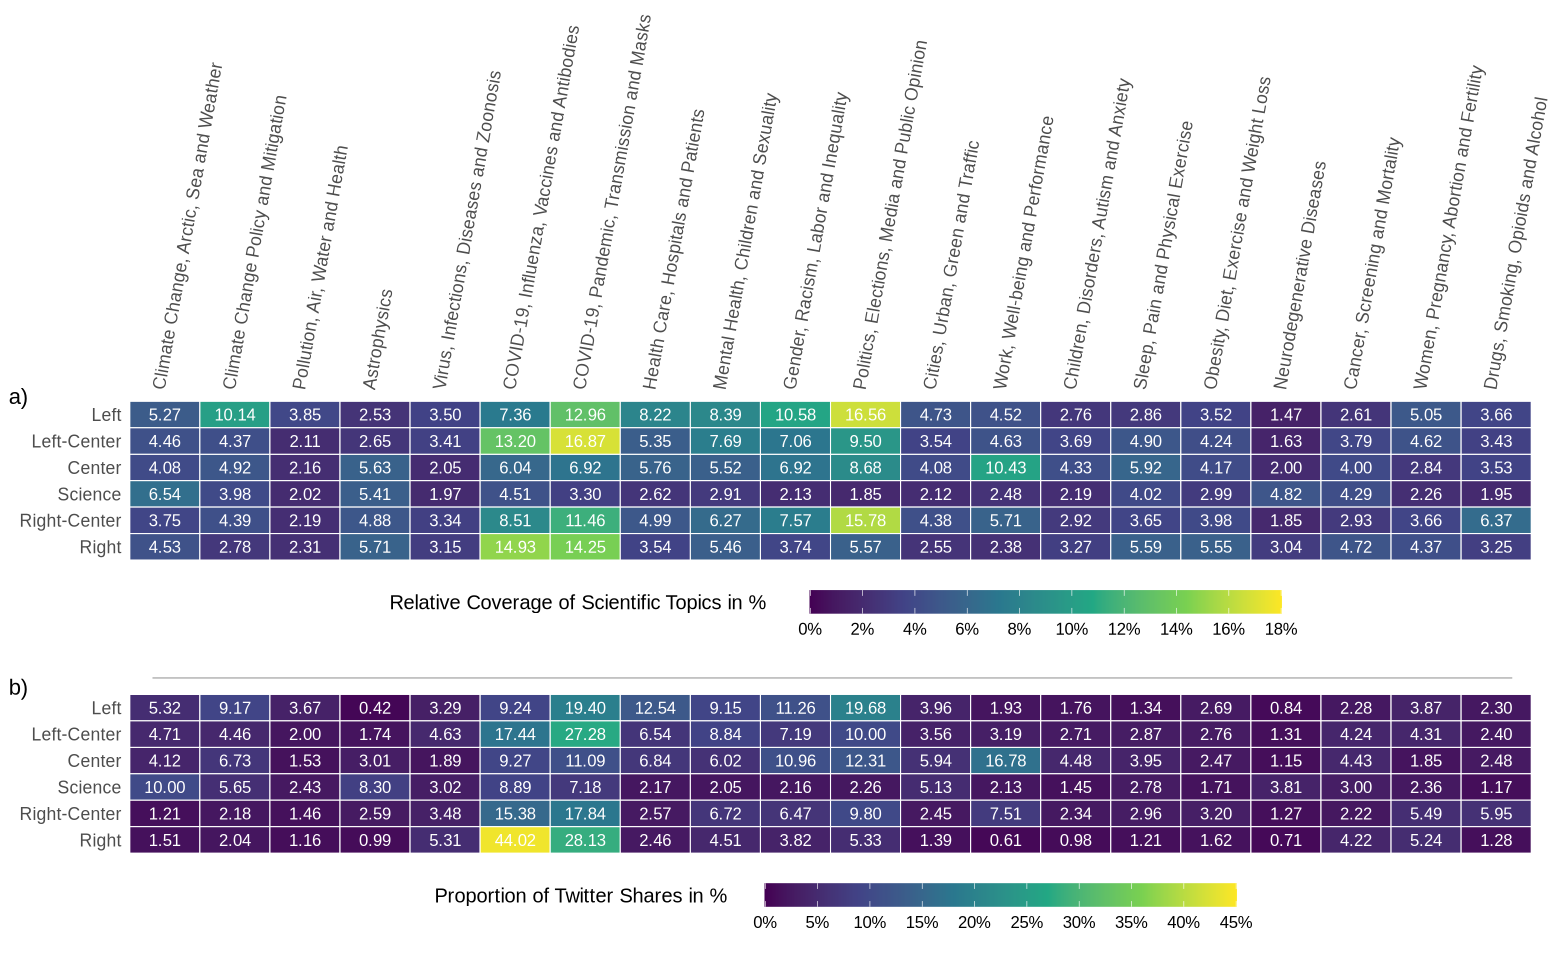

In [31]:
width=13
height=8

library(patchwork)

combined_order <- c("Right", "Right-Center", "Science", "Center", "Left-Center", "Left")
num_articles_results$bias_label    <- factor(num_articles_results$bias_label, levels = combined_order)
prevalence_pol_results$bias_label <- factor(prevalence_pol_results$bias_label, levels = combined_order)
sharing_results$bias_label         <- factor(sharing_results$bias_label, levels = combined_order)
num_shares_results$bias_label         <- factor(num_shares_results$bias_label, levels = combined_order)

exclude_topics = c(0,1,6,7,8,9,10,21,24,25)

# common x-scale
x_scale_common <- scale_x_discrete(
  position = "top",
  expand = expansion(add = c(0.5, 0.65))
)

# create dummy plot with single grey line used to separate the facets
dummy_data <- data.frame(x = factor(0:length(unique(sharing_results$label_fct))), y=0)
p_line <- ggplot(dummy_data, aes(x = x, y = y, group = 1)) +
geom_line(color="grey", linewidth=0.5) + 
x_scale_common + 
labs(x = NULL, y = NULL) + 
theme_void()


# facet 1
p1 <- ggplot(num_articles_results %>% filter(!topic %in% exclude_topics), aes(x = label_fct, y = bias_label, fill = prop100)) +
  geom_tile(color = "white", linewidth = 0.3) +
  geom_text(aes(label = sprintf("%.2f", prop100)), colour = "white", size = 10/.pt) +
  scale_fill_viridis_c(name = "Relative Coverage of Scientific Topics in %", limits = c(0, 18), breaks = seq(0, 18, by = 2), labels = function(x) sprintf("%d%%", x), 
                       guide = guide_colorbar(
                           barwidth  = unit(10, "cm"),
                           barheight = unit(0.5, "cm"),
                           title.position = "left",
                           title.hjust = 0,
                           title.theme = element_text(
                              angle = 0,
                              margin = margin(t = -15, r = 20, b = 0, l = 0)  # adjust top margin to center on bar
                            )
                       )
                      ) +
  x_scale_common +
  labs(x = NULL, y = NULL) +
  theme_minimal() +
  theme(
    panel.grid = element_blank(),
    axis.text.x = element_text(size = 30/.pt, angle = 80, hjust = 0, vjust = 0.5),
    axis.text.y = element_text(size = 30/.pt),
    legend.position = "bottom",
    legend.title = element_text(size = 12),
    legend.text  = element_text(size = 10),
    strip.text = element_text(size = 32/.pt, face = "bold")
  ) 

# facet 2
p2 <- ggplot(num_shares_results %>% filter(!topic %in% exclude_topics), aes(x = label_fct, y = bias_label, fill = prop100)) +
  geom_tile(color = "white", linewidth = 0.3) +
  geom_text(aes(label = sprintf("%.2f", prop100)), colour = "white", size = 10/.pt) +
  scale_fill_viridis_c(name = "Proportion of Twitter Shares in %", 
                       guide = guide_colorbar(
                           barwidth  = unit(10, "cm"),
                           barheight = unit(0.5, "cm"),
                           title.position = "left",
                           title.hjust = 0,
                           title.theme = element_text(
                              angle = 0,
                              margin = margin(t = -15, r = 20, b = 0, l = 0)  # adjust top margin to center on bar
                            )
                       ), 
                     limits = c(0, 45), 
                     breaks = seq(0, 45, by = 5), 
                     labels = function(x) sprintf("%d%%", x)
                      ) +
  x_scale_common +
  labs(x = NULL, y = NULL) +
  theme_minimal() +
  theme(
    panel.grid = element_blank(),
    axis.text.x = element_blank(),
    axis.ticks.x = element_blank(),
    axis.text.y = element_text(size = 30/.pt),
    legend.position = "bottom",
    legend.title = element_text(size = 12),
    legend.text  = element_text(size = 10),
    strip.text = element_text(size = 32/.pt, face = "bold")
  )

final_plot <- (p1 + theme(plot.tag.position = c(0.0, 0.4))) / p_line / (p2 + theme(plot.tag.position = c(0.0, 1))) + plot_layout(heights = c(10, 0.02, 10)) + plot_annotation(tag_levels = list(c("a)", "", "b)")))  # adjust heights

# Render
options(repr.plot.width=width, repr.plot.height=height)
final_plot

### Figure 5

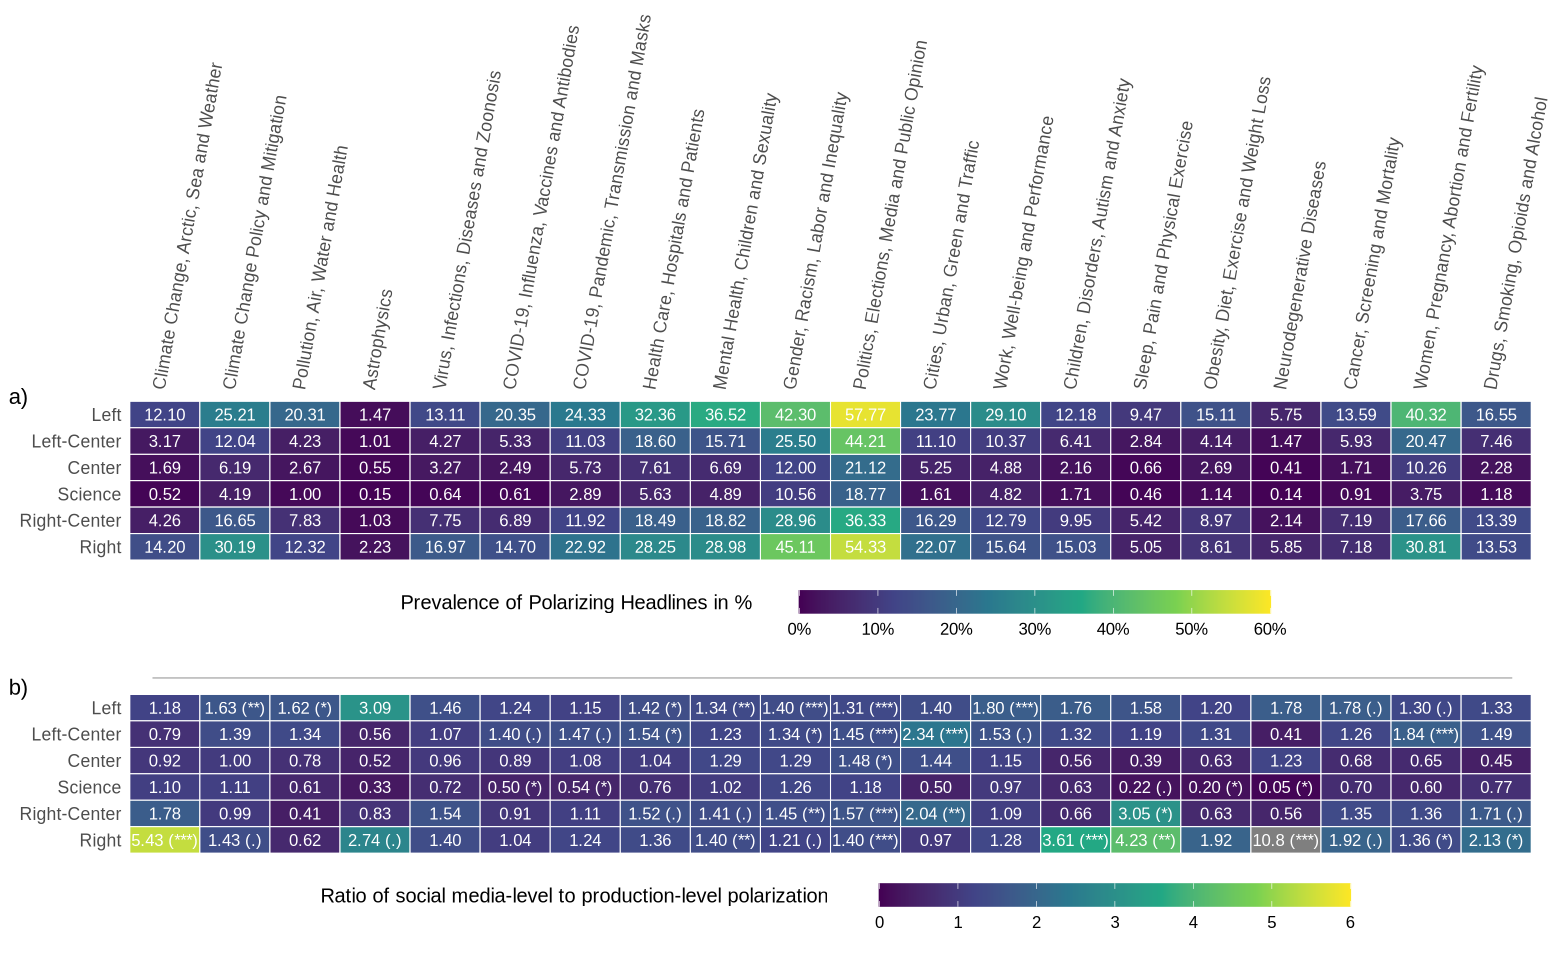

In [32]:
# facet 3
p3 <- ggplot(prevalence_pol_results %>% filter(!topic %in% exclude_topics), aes(x = label_fct, y = bias_label, fill = prop100)) +
  geom_tile(color = "white", linewidth = 0.3) +
  geom_text(aes(label = sprintf("%.2f", prop100)), colour = "white", size = 10/.pt) +
  scale_fill_viridis_c(name = "Prevalence of Polarizing Headlines in %", limits = c(0, 60), breaks = seq(0, 60, by = 10), labels = function(x) sprintf("%d%%", x), 
                       guide = guide_colorbar(
                           barwidth  = unit(10, "cm"),
                           barheight = unit(0.5, "cm"),
                           title.position = "left",
                           title.hjust = 0,
                           title.theme = element_text(
                              angle = 0,
                              margin = margin(t = -15, r = 20, b = 0, l = 0)  # adjust top margin to center on bar
                            )
                       )
                      ) +
  x_scale_common +
  labs(x = NULL, y = NULL) +
  theme_minimal() +
  theme(
    panel.grid = element_blank(),
    axis.text.x = element_text(size = 30/.pt, angle = 80, hjust = 0, vjust = 0.5),
    axis.text.y = element_text(size = 30/.pt),
    legend.position = "bottom",
    legend.title = element_text(size = 12),
    legend.text  = element_text(size = 10),
    strip.text = element_text(size = 32/.pt, face = "bold"),
  ) 

# facet 4
p4 <- ggplot(sharing_results %>% filter(!topic %in% exclude_topics), aes(x = label_fct, y = bias_label, fill = ratio)) +
  geom_tile(color = "white", linewidth = 0.3) +
  geom_text(aes(label = ifelse(sc != "", ifelse(ratio < 10, sprintf("%.2f (%s)", ratio, sc), sprintf("%.1f (%s)", ratio, sc)), sprintf("%.2f", ratio))), colour = "white", size = 10/.pt) +
  scale_fill_viridis_c(name = "Ratio of social media-level to production-level polarization", limits = c(0, 6), breaks = seq(0, 6, by = 1), 
                       guide = guide_colorbar(
                           barwidth  = unit(10, "cm"),
                           barheight = unit(0.5, "cm"),
                           title.position = "left",
                           title.hjust = 0,
                           title.theme = element_text(
                              angle = 0,
                              margin = margin(t = -15, r = 20, b = 0, l = 0)  # adjust top margin to center on bar
                            )
                       )
                      ) +
  x_scale_common +
  labs(x = NULL, y = NULL) +
  theme_minimal() +
  theme(
    panel.grid = element_blank(),
    axis.text.x = element_blank(),
    axis.ticks.x = element_blank(),
    axis.text.y = element_text(size = 30/.pt),
    legend.position = "bottom",
    legend.title = element_text(size = 12),
    legend.text  = element_text(size = 10),
    strip.text = element_text(size = 32/.pt, face = "bold")
  )


#final_plot <- p3 / p_line / p4 + plot_layout(heights = c(10, 0.05, 10))  # adjust heights
final_plot <- (p3 + theme(plot.tag.position = c(0.0, 0.4))) / p_line / (p4 + theme(plot.tag.position = c(0.0, 1))) + plot_layout(heights = c(10, 0.02, 10)) + plot_annotation(tag_levels = list(c("a)", "", "b)")))  # adjust heights

# Render
options(repr.plot.width=width, repr.plot.height=height)
final_plot

### Figure 8

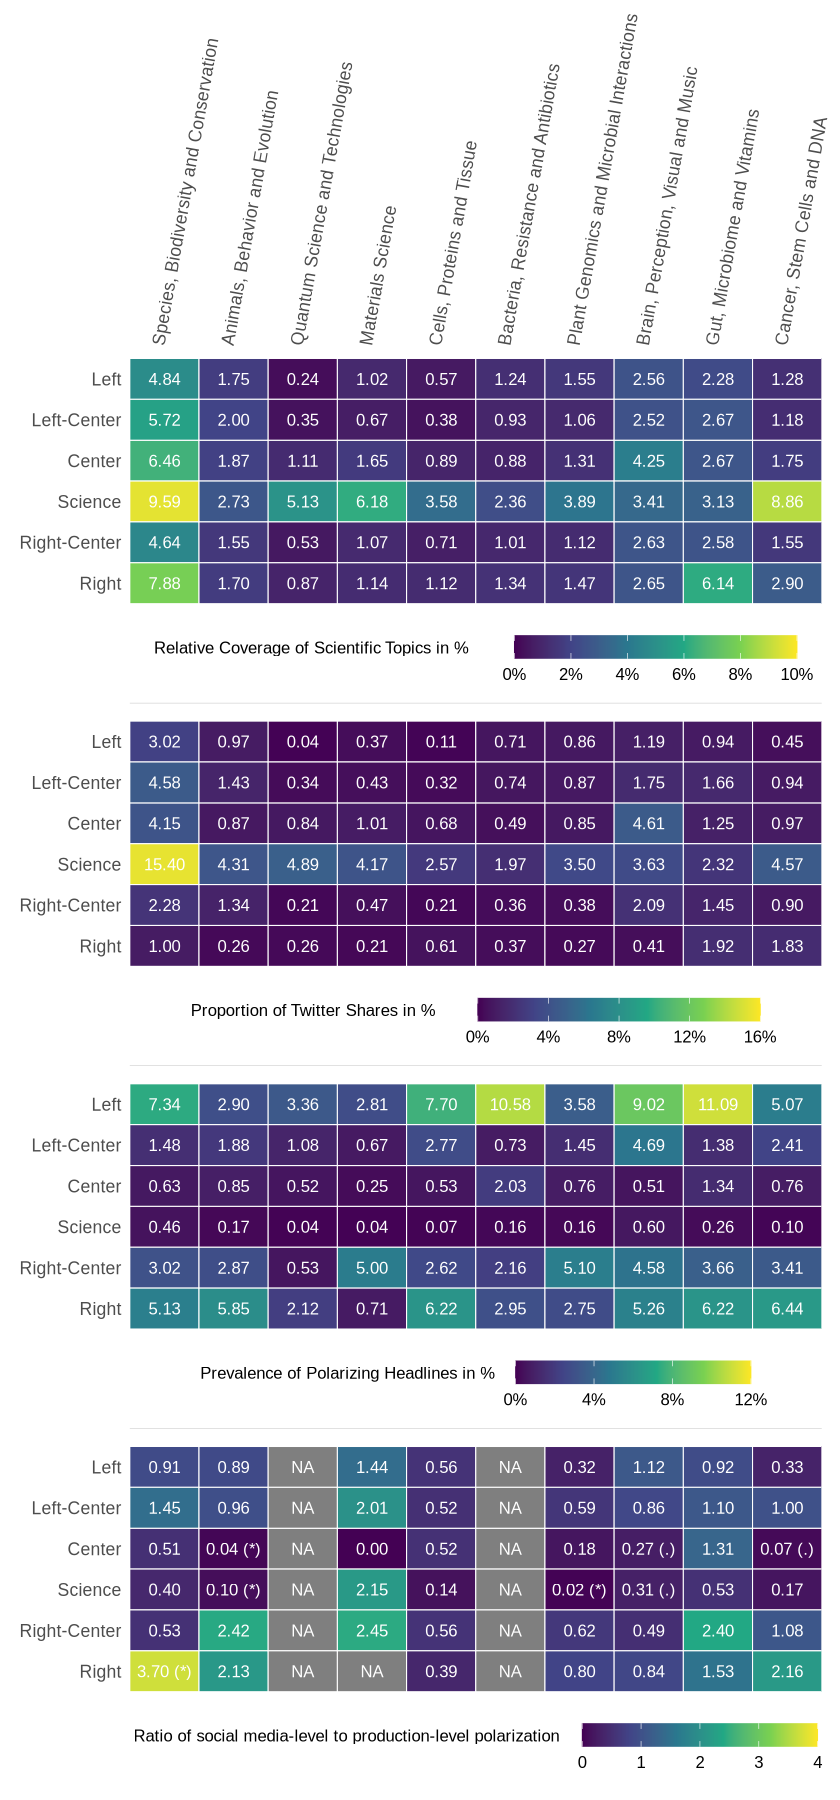

In [33]:
width=7
height=15

library(patchwork)

combined_order <- c("Right", "Right-Center", "Science", "Center", "Left-Center", "Left")
num_articles_results$bias_label    <- factor(num_articles_results$bias_label, levels = combined_order)
prevalence_pol_results$bias_label <- factor(prevalence_pol_results$bias_label, levels = combined_order)
sharing_results$bias_label         <- factor(sharing_results$bias_label, levels = combined_order)
num_shares_results$bias_label         <- factor(num_shares_results$bias_label, levels = combined_order)

exclude_topics = c(0,1,6,7,8,9,10,21,24,25)

# common x-scale
x_scale_common <- scale_x_discrete(
  position = "top",
  expand = expansion(add = c(0, 0))
)


# create dummy plot with single grey line used to separate the facets
dummy_data <- data.frame(x = factor(0:length(unique(sharing_results$label_fct))), y=0)
p_line <- ggplot(dummy_data, aes(x = x, y = y, group = 1)) +
geom_line(color="grey", linewidth=0.5) + 
x_scale_common + 
labs(x = NULL, y = NULL) + 
theme_void()


# facet 1
p1 <- ggplot(num_articles_results %>% filter(topic %in% exclude_topics), aes(x = label_fct, y = bias_label, fill = prop100)) +
  geom_tile(color = "white", linewidth = 0.3) +
  geom_text(aes(label = sprintf("%.2f", prop100)), colour = "white", size = 10/.pt) +
  scale_fill_viridis_c(name = "Relative Coverage of Scientific Topics in %", limits = c(0, 10), breaks = seq(0, 10, by = 2), labels = function(x) sprintf("%d%%", x), 
                       guide = guide_colorbar(
                           barwidth  = unit(6, "cm"),
                           barheight = unit(0.5, "cm"),
                           title.position = "left",
                           title.hjust = 0,
                           title.theme = element_text(
                              angle = 0,
                              margin = margin(t = -15, r = 20, b = 0, l = 0)  # adjust top margin to center on bar
                            )
                       )
                      ) +
  x_scale_common +
  labs(x = NULL, y = NULL) +
  theme_minimal() +
  theme(
    panel.grid = element_blank(),
    axis.text.x = element_text(size = 30/.pt, angle = 80, hjust = 0, vjust = 0.5),
    axis.text.y = element_text(size = 30/.pt),
    legend.position = "bottom",
    legend.title = element_text(size = 10),
    legend.text  = element_text(size = 10),
    strip.text = element_text(size = 32/.pt, face = "bold")
  ) 

# facet 2
p2 <- ggplot(num_shares_results %>% filter(topic %in% exclude_topics), aes(x = label_fct, y = bias_label, fill = prop100)) +
  geom_tile(color = "white", linewidth = 0.3) +
  geom_text(aes(label = sprintf("%.2f", prop100)), colour = "white", size = 10/.pt) +
  scale_fill_viridis_c(name = "Proportion of Twitter Shares in %", 
                       guide = guide_colorbar(
                           barwidth  = unit(6, "cm"),
                           barheight = unit(0.5, "cm"),
                           title.position = "left",
                           title.hjust = 0,
                           title.theme = element_text(
                              angle = 0,
                              margin = margin(t = -15, r = 20, b = 0, l = 0)  # adjust top margin to center on bar
                            )
                       ), 
                     limits = c(0, 16), 
                     breaks = seq(0, 16, by = 4), 
                     labels = function(x) sprintf("%d%%", x)
                      ) +
  x_scale_common +
  labs(x = NULL, y = NULL) +
  theme_minimal() +
  theme(
    panel.grid = element_blank(),
    axis.text.x = element_blank(),
    axis.ticks.x = element_blank(),
    axis.text.y = element_text(size = 30/.pt),
    legend.position = "bottom",
    legend.title = element_text(size = 10),
    legend.text  = element_text(size = 10),
    strip.text = element_text(size = 32/.pt, face = "bold")
  )

# facet 3
p3 <- ggplot(prevalence_pol_results %>% filter(topic %in% exclude_topics), aes(x = label_fct, y = bias_label, fill = prop100)) +
  geom_tile(color = "white", linewidth = 0.3) +
  geom_text(aes(label = sprintf("%.2f", prop100)), colour = "white", size = 10/.pt) +
  scale_fill_viridis_c(name = "Prevalence of Polarizing Headlines in %", limits = c(0, 12), breaks = seq(0, 12, by = 4), labels = function(x) sprintf("%d%%", x), 
                       guide = guide_colorbar(
                           barwidth  = unit(5, "cm"),
                           barheight = unit(0.5, "cm"),
                           title.position = "left",
                           title.hjust = 0,
                           title.theme = element_text(
                              angle = 0,
                              margin = margin(t = -15, r = 5, b = 0, l = 0)  # adjust top margin to center on bar
                            )
                       )
                      ) +
  x_scale_common +
  labs(x = NULL, y = NULL) +
  theme_minimal() +
  theme(
    panel.grid = element_blank(),
    axis.text.x = element_blank(),
    axis.ticks.x = element_blank(),
    axis.text.y = element_text(size = 30/.pt),
    legend.position = "bottom",
    legend.title = element_text(size = 10),
    legend.text  = element_text(size = 10),
    strip.text = element_text(size = 32/.pt, face = "bold")
  )
# facet 4
sharing_results$ratio[is.nan(sharing_results$p.value)] <- NA
sharing_results$ratio[is.nan(sharing_results$ratio)] <- NA
sharing_results$sc[is.na(sharing_results$sc)] <- ""

p4 <- ggplot(sharing_results %>% filter(topic %in% exclude_topics), aes(x = label_fct, y = bias_label, fill = ratio)) +
  geom_tile(color = "white", linewidth = 0.3) +
  geom_text(aes(label = ifelse(sc != "", ifelse(ratio < 10, sprintf("%.2f (%s)", ratio, sc), sprintf("%.1f (%s)", ratio, sc)), sprintf("%.2f", ratio))), colour = "white", size = 10/.pt) +
  scale_fill_viridis_c(name = "Ratio of social media-level to production-level polarization", limits = c(0, 4), breaks = seq(0, 4, by = 1), 
                       guide = guide_colorbar(
                           barwidth  = unit(5, "cm"),
                           barheight = unit(0.5, "cm"),
                           title.position = "left",
                           title.hjust = 0,
                           title.theme = element_text(
                              angle = 0,
                              margin = margin(t = -15, r = 5, b = 0, l = 0)  # adjust top margin to center on bar
                            )
                       )
                      ) +
  x_scale_common +
  labs(x = NULL, y = NULL) +
  theme_minimal() +
  theme(
    panel.grid = element_blank(),
    axis.text.x = element_blank(),
    axis.ticks.x = element_blank(),
    axis.text.y = element_text(size = 30/.pt),
    legend.position = "bottom",
    legend.title = element_text(size = 10),
    legend.text  = element_text(size = 10),
    strip.text = element_text(size = 32/.pt, face = "bold")
  )


final_plot <- p1 / p_line / p2 / p_line / p3 / p_line / p4 + plot_layout(heights = c(10, 0.02, 10, 0.02, 10, 0.02, 10))  # adjust heights

# Render
options(repr.plot.width=width, repr.plot.height=height)
final_plot

## Bootstrap Analysis

In [ ]:
new_data <- data %>% select(hp, topic, bias, news_domain, X1p_ntweets)

news_data <- new_data
news_data$group <- "all"

shared_weighted_data <- new_data %>% filter(X1p_ntweets > 0)
shared_weighted_data$group <- "shared_weighted"

combined_data <- rbind(
  transform(news_data, weight = 1),
  transform(shared_weighted_data, weight = X1p_ntweets)
)

combined_data$hp <- ifelse(tolower(combined_data$hp) == "true", 1, 0)
combined_data$bias <- factor(combined_data$bias)
combined_data$bias <- relevel(combined_data$bias, ref = "3_Center")
combined_data$news_domain <- factor(combined_data$news_domain)

print(table(combined_data$bias, useNA = "ifany"))                 


# Function to bootstrap social media while keeping production data fixed
bootstrap_social_with_production <- function(production_data, social_data, target_topic, B = 500) {
  
  # Filter to the target topic
  prod_window <- production_data %>% filter(sapply(topic, function(x) target_topic %in% x))
  social_window <- social_data %>% filter(sapply(topic, function(x) target_topic %in% x))
  
  if(nrow(social_window) < 10) return(NULL)

  # Progress bar
  pb <- progress_bar$new(
    format = "  Bootstrapping [:bar] :percent eta: :eta",
    total = B, clear = FALSE, width = 60
  )

   # Initialize matrix to store bootstrap contrasts
  n_bias <- length(levels(social_window$bias))
  boot_matrix <- matrix(NA, nrow = n_bias, ncol = B)
  rownames(boot_matrix) <- levels(social_window$bias)
  
  for(b in 1:B) {
    
    # Update progress bar
    pb$tick()
        
    # Resample social media-level articles
    indices <- sample(1:nrow(social_window), replace = TRUE)
    social_boot <- social_window[indices, ]
        
    # Combine with production data (fixed)
    combined_boot <- bind_rows(prod_window, social_boot)
    
    # Fit GLMM
    model_hp_shares <- glmmTMB(hp ~ 1 + group*bias + (1+group|news_domain), data=combined_boot, family="binomial", weights=weight, control=glmmTMBControl(rank_check="adjust", parallel=2))

    # Extract contrasts for social media vs production
    e <- contrast(regrid(emmeans(model_hp_shares, ~ group | bias, infer=c(TRUE,TRUE), type="response"), "log"), method = "revpairwise", by="bias")
    r <- summary(e, infer = FALSE)$ratio

    #print(summary(e)$ratio)
    #flush.console()
    
    boot_matrix[, b] <- r

    }

      # Remove columns with all NA
    boot_matrix <- boot_matrix[, colSums(is.na(boot_matrix)) < nrow(boot_matrix)]
    
    # Summarize: median and 95% CI
    boot_summary <- apply(boot_matrix, 1, function(x) {
      c(median = median(x, na.rm = TRUE),
        lower = quantile(x, 0.025, na.rm = TRUE),
        upper = quantile(x, 0.975, na.rm = TRUE))
    })
  
  return(boot_summary)
}

# --- Apply per topic ---
production_data <- combined_data %>% filter(group == "all")
social_data <- combined_data %>% filter(group == "shared_weighted")

sharing_results_boot <- list()

for(target_topic in all_unique_topics) {
  cat("Bootstrapping topic:", target_topic, "\n")
  flush.console()
  
  res <- bootstrap_social_with_production(production_data, social_data, target_topic, B = 200)
  print(res)  
  flush.console()

  if(!is.null(res)) sharing_results_boot[[target_topic+1]] <- res
}

In [34]:
#remove 
filename <- "sharing_results_boot_200.rds"
sharing_results_boot <- readRDS(file = filename)

In [35]:
boot_df <- imap_dfr(sharing_results_boot, function(mat, topic_id) {
  
  as.data.frame(t(mat)) %>%
    mutate(
      topic = topic_id,
      outlet_group = rownames(.)
    ) %>%
    relocate(topic, outlet_group)
})

boot_df <- boot_df %>%
  rename(
    median = median,
    lower = `lower.2.5%`,
    upper = `upper.97.5%`
  )

boot_df <- boot_df %>%
  mutate(
    cell = sprintf("%.2f [%.2f, %.2f]", median, lower, upper)
  ) %>%
  select(topic, outlet_group, cell)

In [36]:
boot_wide <- boot_df %>%
  pivot_wider(
    names_from = outlet_group,
    values_from = cell
  ) %>%
  arrange(as.numeric(topic))

boot_wide$topic <- boot_wide$topic - 1

topic2label <- fromJSON('kmeans_topic2labels.json')
topic2label$topic <- as.character(topic2label$topic)

boot_wide$topic <- as.character(boot_wide$topic)
boot_wide <- boot_wide %>% select(-any_of("label"))
boot_wide <- left_join(boot_wide, topic2label, by = "topic")

boot_wide

topic,3_Center,1_Left,2_Left-Center,4_Science,5_Right-Center,6_Right,label
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
0,"0.31 [0.11, 0.69]","0.64 [0.21, 1.33]","1.08 [0.53, 1.77]","0.25 [0.09, 0.52]","0.38 [0.07, 0.89]","2.83 [0.94, 5.41]","Species, Biodiversity and Conservation"
1,"0.01 [0.00, 0.09]","0.33 [0.02, 1.32]","0.46 [0.07, 1.09]","0.03 [0.01, 0.14]","0.79 [0.00, 4.73]","2.39 [0.22, 9.65]","Animals, Behavior and Evolution"
2,"0.51 [0.18, 1.14]","0.85 [0.33, 1.62]","0.62 [0.28, 0.93]","0.62 [0.17, 1.34]","0.90 [0.20, 2.32]","5.20 [3.60, 6.15]","Climate Change, Arctic, Sea and Weather"
3,"0.83 [0.50, 1.27]","1.47 [0.99, 1.89]","1.25 [0.89, 1.69]","0.95 [0.63, 1.39]","0.83 [0.51, 1.29]","1.43 [0.99, 1.91]",Climate Change Policy and Mitigation
4,"0.45 [0.13, 0.96]","1.40 [0.77, 2.04]","0.91 [0.38, 1.55]","0.30 [0.07, 0.69]","0.24 [0.04, 0.63]","0.48 [0.18, 1.25]","Pollution, Air, Water and Health"
5,"0.31 [0.07, 1.02]","1.92 [0.00, 4.95]","0.43 [0.16, 0.90]","0.16 [0.06, 0.73]","0.53 [0.06, 2.23]","2.24 [0.35, 5.33]",Astrophysics
6,"0.39 [0.01, 3.26]","3.11 [0.00, 30.99]","0.04 [0.00, 0.93]","0.03 [0.00, 1.30]","0.00 [0.00, 0.00]","0.07 [0.00, 1.16]",Quantum Science and Technologies
7,"0.00 [0.00, 0.00]","0.70 [0.03, 2.70]","0.07 [0.00, 2.51]","0.18 [0.00, 2.12]","1.05 [0.01, 5.05]","0.00 [0.00, 0.00]",Materials Science
8,"0.11 [0.00, 0.99]","0.34 [0.00, 2.81]","0.16 [0.01, 1.34]","0.03 [0.00, 0.26]","0.28 [0.00, 1.42]","0.18 [0.01, 1.60]","Cells, Proteins and Tissue"


### Table 5

In [37]:
boot_wide_overleaf <- boot_wide %>%
  select(
    label,
    `1_Left`,
    `2_Left-Center`,
    `3_Center`,
    `4_Science`,
    `5_Right-Center`,
    `6_Right`
  ) %>%
  rename(
    Left = `1_Left`,
    `Left-Center` = `2_Left-Center`,
    Center = `3_Center`,
    Science = `4_Science`,
    `Right-Center` = `5_Right-Center`,
    Right = `6_Right`
  )

kable(
  boot_wide_overleaf,
  format = "latex",
  booktabs = TRUE,
  caption = "Median bootstrapped contrasts (95% CI in brackets) between social media and production-level polarization by scientific topic and outlet group.",
  label = "tab:bootstrap_contrasts",
  escape = FALSE
)

\begin{table}

\caption{\label{tab:tab:bootstrap_contrasts}Median bootstrapped contrasts (95% CI in brackets) between social media and production-level polarization by scientific topic and outlet group.}
\centering
\begin{tabular}[t]{lllllll}
\toprule
label & Left & Left-Center & Center & Science & Right-Center & Right\\
\midrule
Species, Biodiversity and Conservation & 0.64 [0.21, 1.33] & 1.08 [0.53, 1.77] & 0.31 [0.11, 0.69] & 0.25 [0.09, 0.52] & 0.38 [0.07, 0.89] & 2.83 [0.94, 5.41]\\
Animals, Behavior and Evolution & 0.33 [0.02, 1.32] & 0.46 [0.07, 1.09] & 0.01 [0.00, 0.09] & 0.03 [0.01, 0.14] & 0.79 [0.00, 4.73] & 2.39 [0.22, 9.65]\\
Climate Change, Arctic, Sea and Weather & 0.85 [0.33, 1.62] & 0.62 [0.28, 0.93] & 0.51 [0.18, 1.14] & 0.62 [0.17, 1.34] & 0.90 [0.20, 2.32] & 5.20 [3.60, 6.15]\\
Climate Change Policy and Mitigation & 1.47 [0.99, 1.89] & 1.25 [0.89, 1.69] & 0.83 [0.50, 1.27] & 0.95 [0.63, 1.39] & 0.83 [0.51, 1.29] & 1.43 [0.99, 1.91]\\
Pollution, Air, Water and Health